## Data Processing :

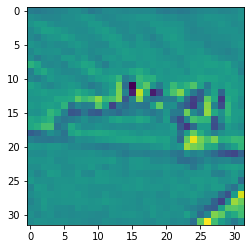

In [30]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

# Reading images as dataframes
train_images_df = pd.read_csv('./drive/MyDrive/kernel/Xtr.csv', header=None)
labels_df = pd.read_csv('./drive/MyDrive/kernel/Ytr.csv')
train_images_df = train_images_df.loc[:,:3071]

test_images_df = pd.read_csv('./drive/MyDrive/kernel/Xte.csv', header=None)
test_images_df = test_images_df.loc[:,:3071]

train_images = train_images_df.values
labels = labels_df.Prediction

test_images = test_images_df.values

#  Construction of the data
r, g, b = np.hsplit(train_images, 3)
train_data = np.array([np.dstack((r[i], b[i], g[i])).reshape(32, 32, 3) for i in range(len(train_images))])

r, g, b = np.hsplit(test_images, 3)
data_test = np.array([np.dstack((r[i], b[i], g[i])).reshape(32, 32, 3) for i in range(len(test_images))])

#  Data Visualisation 
black_white_images = np.sum(np.hsplit(train_images, 3), axis=0)/3
gray_images = np.array([black_white_images[i].reshape((32, 32)) for i in range(len(train_images))])
i = np.random.choice(range(5000))
image = gray_images[i] 
plt.imshow(image)
plt.show()

## Data Augmentation

In [47]:
# Flipping horintally and vertically image from the train set
import cv2

augmented_train = []

for row in range(0, len(train_data)):
    augmented_train.append(train_data[row])
    augmented_train.append(cv2.flip(train_data[row],np.random.choice([0,1])))

augmented_train=np.array(augmented_train)
    
# augmented labels

augmented_labels = []
for row in range(len(train_data)):
    i = labels[row]
    augmented_labels.append(i)
    augmented_labels.append(i)
    
augmented_labels = np.array(augmented_labels)

In [50]:
len(augmented_train)

10000

## Feature Extraction:

In [ ]:
import sys

In [55]:
class SIFT:
    # CONSTUCTOR 
    def __init__(self, gs = 8, ps = 16, gaussian_thres = 1.0, gaussian_sigma = 0.8, sift_thres = 0.2, \
                 num_angles = 12, num_bins = 5, alpha = 9.0):
        self.num_angles = num_angles
        self.num_bins = num_bins
        self.alpha = alpha
        self.angle_list = np.array(range(num_angles))*2.0*np.pi/num_angles
        self.gs = gs
        self.ps = ps
        self.gaussian_thres = gaussian_thres
        self.gaussian_sigma = gaussian_sigma
        self.sift_thres = sift_thres
        self.weights = self._get_weights(num_bins)

    def get_params_image(self, image):
        image = image.astype(np.double)
        if image.ndim == 3:
            image = np.mean(image, axis=2)
        H, W = image.shape
        gS = self.gs
        pS = self.ps
        remH = np.mod(H-pS, gS)
        remW = np.mod(W-pS, gS)
        offsetH = int(remH/2)
        offsetW = int(remW/2)
        gridH, gridW = np.meshgrid(range(offsetH, H-pS+1, gS), range(offsetW, W-pS+1, gS))
        gridH = gridH.flatten()
        gridW = gridW.flatten()
        features = self._calculate_sift_grid(image, gridH, gridW)
        features = self._normalize_sift(features)
        positions = np.vstack((gridH / np.double(H), gridW / np.double(W)))
        return features, positions
    
    def get_X(self, data):
        out = []
        for idx, dt in enumerate(data):
            out.append(self.get_params_image(np.mean(np.double(dt), axis=2))[0][0])
        return np.array(out)

    # PRIVATE METHODS 
    def _get_weights(self, num_bins):
        size_unit = np.array(range(self.ps))
        sph, spw = np.meshgrid(size_unit, size_unit)
        sph.resize(sph.size)
        spw.resize(spw.size)
        bincenter = np.array(range(1, num_bins*2, 2)) / 2.0 / num_bins * self.ps - 0.5
        bincenter_h, bincenter_w = np.meshgrid(bincenter, bincenter)
        bincenter_h.resize((bincenter_h.size, 1))
        bincenter_w.resize((bincenter_w.size, 1))
        dist_ph = abs(sph - bincenter_h)
        dist_pw = abs(spw - bincenter_w)
        weights_h = dist_ph / (self.ps / np.double(num_bins))
        weights_w = dist_pw / (self.ps / np.double(num_bins))
        weights_h = (1-weights_h) * (weights_h <= 1)
        weights_w = (1-weights_w) * (weights_w <= 1)
        return weights_h * weights_w

    def _calculate_sift_grid(self, image, gridH, gridW):
        H, W = image.shape
        Npatches = gridH.size
        features = np.zeros((Npatches, self.num_bins * self.num_bins * self.num_angles))
        gaussian_height, gaussian_width = self._get_gauss_filter(self.gaussian_sigma)
        IH = self._convolution2D(image, gaussian_height)
        IW = self._convolution2D(image, gaussian_width)
        Imag = np.sqrt(IH**2 + IW**2)
        Itheta = np.arctan2(IH,IW)
        Iorient = np.zeros((self.num_angles, H, W))
        for i in range(self.num_angles):
            Iorient[i] = Imag * np.maximum(np.cos(Itheta - self.angle_list[i])**self.alpha, 0)
        for i in range(Npatches):
            currFeature = np.zeros((self.num_angles, self.num_bins**2))
            for j in range(self.num_angles):
                currFeature[j] = np.dot(self.weights,\
                        Iorient[j,gridH[i]:gridH[i]+self.ps, gridW[i]:gridW[i]+self.ps].flatten())
            features[i] = currFeature.flatten()
        return features

    def _normalize_sift(self, features):
        siftlen = np.sqrt(np.sum(features**2, axis=1))
        hcontrast = (siftlen >= self.gaussian_thres)
        siftlen[siftlen < self.gaussian_thres] = self.gaussian_thres
        features /= siftlen.reshape((siftlen.size, 1))
        features[features>self.sift_thres] = self.sift_thres
        features[hcontrast] /= np.sqrt(np.sum(features[hcontrast]**2, axis=1)).\
                reshape((features[hcontrast].shape[0], 1))
        return features


    def _get_gauss_filter(self, sigma):
        gaussian_filter_amp = np.int(2*np.ceil(sigma))
        gaussian_filter = np.array(range(-gaussian_filter_amp, gaussian_filter_amp+1))**2
        gaussian_filter = gaussian_filter[:, np.newaxis] + gaussian_filter
        gaussian_filter = np.exp(- gaussian_filter / (2.0 * sigma**2))
        gaussian_filter /= np.sum(gaussian_filter)
        gaussian_height, gaussian_width = np.gradient(gaussian_filter)
        gaussian_height *= 2.0/np.sum(np.abs(gaussian_height))
        gaussian_width  *= 2.0/np.sum(np.abs(gaussian_width))
        return gaussian_height, gaussian_width
    
    def _convolution2D(self, image, kernel):
        imRows, imCols = image.shape
        kRows, kCols = kernel.shape

        y = np.zeros((imRows,imCols))

        kcenterX = kCols//2
        kcenterY = kRows//2

        for i in range(imRows):
            for j in range(imCols):
                for m in range(kRows):
                    mm = kRows - 1 - m
                    for n in range(kCols):
                        nn = kCols - 1 - n

                        ii = i + (m - kcenterY)
                        jj = j + (n - kcenterX)

                        if ii >= 0 and ii < imRows and jj >= 0 and jj < imCols :
                            y[i][j] += image[ii][jj] * kernel[mm][nn]

        return y

In [82]:
params = { 'gs': 6,
           'gamma': .6,
           'A': 10.,
           'ps': 31,
           'sift_thres': .3,
           'gaussian_thres': .7,
           'gaussian_sigma': .4,
           'num_angles': 12,
           'num_bins': 5,
           'alpha': 9.0 }

In [58]:
extractor = SIFT(gs=params['gs'], 
                 ps=params['ps'], 
                 sift_thres=params['sift_thres'], 
                 gaussian_sigma=params['gaussian_sigma'], 
                 gaussian_thres=params['gaussian_thres'],
                 num_angles=params['num_angles'],
                 num_bins=params['num_bins'],
                 alpha=params['alpha'])

In [ ]:
X_train = extractor.get_X(augmented_train)

In [ ]:
X_test = extractor.get_X(data_test)

### Kernels

In [74]:
def euclidean_dist(X, Y):
    """
    matrix of pairwise squared Euclidean distances
    """
    norms_1 = (X ** 2).sum(axis=1)
    norms_2 = (Y ** 2).sum(axis=1)
    return np.abs(norms_1.reshape(-1, 1) + norms_2 - 2 * np.dot(X, Y.T))

In [65]:
class Kernel:

    def linear():
        def f(X1, X2):
            return X1.dot(X2.T)
        return f
    
    def quadratic():
      def f(X1, X2):
        return (np.dot(X1, X2.T) ** 2)
      return f

    def gaussian(gamma=5.0):
      def f(X1, X2, gamma=5.0):
        return np.exp(-np.linalg.norm(X1 - X2) ** 2 / (2 * (gamma ** 2)))
      return f

    def chi2(gamma):
        def f(X1, X2):
            out = np.zeros((X1.shape[0], X2.shape[0]))
            n_X1 = X1.shape[0]
            n_X2 = X2.shape[0]
            n_features = X1.shape[1]

            for i in range(n_X1):
                for j in range(n_X2):
                    p = 0
                    for k in range(n_features):
                        denominateur = (X1[i, k] - X2[j, k])
                        nominateur = (X1[i, k] + X2[j, k])
                        if nominateur != 0:
                            p += denominateur * denominateur / nominateur
                    out[i, j] = -p
            tmp = gamma * out
            return  np.exp(tmp, tmp)        
        return f

    def rbf(gamma=1.):
        def f(X1, X2, gamma=1.):
            dists = euclidean_dist(X1, X2)
            return np.exp(-gamma * dists)
        return f

    def laplacian(sigma=1):
      def f(X1,X2, sigma=1):
        dists = euclidean_dist(X1, X2)
        return np.exp(-1 / sigma * np.sqrt(dists))
      return f

Kernel Methods


Ridge Regression



In [66]:
import numpy as np
from scipy.linalg import sqrtm,solve,inv

In [67]:
class KRR(object):
    '''
    A class implementing Kernel Ridge Regression
    '''
    def __init__(self, lmbd=0.1):
        self.lmbd = lmbd
        
    def fit(self,kernel_train,labels):
        A = kernel_train + self.lmbd * len(kernel_train) * np.eye(len(kernel_train))
        self.alpha = solve(A, labels, sym_pos=True)
        self.alpha = np.nan_to_num(self.alpha)

    def predict(self,kernel_test):
        return np.dot(kernel_test, self.alpha)

In [68]:
def predict_class(prediction):
    return [int(pred) for pred in prediction]
def score(prediction,y):
    return np.mean(prediction==y)

Parameters tunuing and Scoring ;

In [69]:
def cross_validation(X, y, nb_folds):
    subset_size = int(len(X) / nb_folds)
    for k in range(nb_folds):
        X_train = np.concatenate((X[:k * subset_size], X[(k + 1) * subset_size:]), axis=0)
        X_test = X[k * subset_size:][:subset_size]
        y_train =  np.concatenate((y[:k * subset_size], y[(k + 1) * subset_size:]), axis=0)
        y_test = y[k * subset_size:][:subset_size]
        yield X_train, y_train, X_test, y_test

In [76]:
lmbds = [0.000001,0.00001,0.0001,0.001,0.01,0.1] 
scores = []
for lmbd, iteration in zip(lmbds,cross_validation(X_train, augmented_labels , 6)):
    X_tr, y_tr, X_te, y_te = iteration 
    clf = KRR(lmbd)
    kernel_train = Kernel.rbf()(X_tr,X_tr) 
    kernel_test = Kernel.rbf()(X_te,X_tr)
    clf.fit(kernel_train,y_tr)
    preds = clf.predict(kernel_test)
    label = predict_class(preds)
    scores.append(score(label,y_te))

In [ ]:
scores

In [ ]:
clf = KRR(0.000001) 

In [ ]:
for X_tr, y_tr, X_te, y_te in cross_validation(X_train, augmented_labels , 10):
    kernel_train = rbf_kernel(X_tr,X_tr) 
    kernel_test = rbf_kernel(X_te,X_tr)
    clf.fit(kernel_train,y_tr)
    preds = clf.predict(kernel_test)
    label = predict_class(preds)
    scores.append(score(label,y_te))

In [ ]:
np.mean(scores)

0.14896689444644218

In [ ]:
# best : 0.0001, rbf_kernel

Logistic Regression

Weighted ridge regression

In [ ]:
import numpy as np
from scipy.linalg import sqrtm,solve,inv

class WKRR(object):
    '''
    A class implementing Weighted Kernel Ridge Regression
    '''
    def __init__(self, lmbd=0.1):
        self.lmbd = lmbd

    def fit(self,kernel_train, labels , Weights):
        W_12 = np.sqrt(Weights)
        n = kernel_train.shape[0]
        to_inv = np.dot(W_12,np.dot(kernel_train,W_12).T)+n*self.lmbd*np.eye(n)
        to_inv = np.linalg.inv(to_inv)
        self.alpha = np.dot(np.dot(W_12,np.dot(to_inv,W_12).T),labels)
    
    def get_coef(self):
        return self.alpha
    
    def predict(self,kernel_test):
        return np.dot(kernel_test,self.alpha)

In [ ]:
sigmoid = lambda x:1/(1+np.exp(-x))
def compute_W(K,y,alpha):
    m = np.dot(K,alpha)
    return np.array([sigmoid(y[i]*m[i])*sigmoid(-y[i]*m[i]) for i in range(len(m))])
def compute_Z(K,y,alpha):
    m = np.dot(K,alpha)
    return np.array([m[i]+y[i]/sigmoid(y[i]*m[i]) for i in range(len(m))])

In [ ]:
class KernelLogisticRegression:
    def __init__(self,init_coef=0):
        if init_coef==0:
            self.alpha_ = 0
    
    def fit(self,kernel_train,labels,alpha=None,tolerance=1,lambda_regularisation=0):
        
        if np.array((alpha==None)).any():
            alpha = np.random.rand(kernel_train.shape[0],1)
        
        old_alpha = np.array(alpha)
        W = np.nan_to_num(compute_W(kernel_train,labels,alpha))
        z = np.nan_to_num(compute_Z(kernel_train,labels,alpha))
        WKR = WKRR(lmbd = lambda_regularisation)
        WKR.fit(kernel_train,labels,z)
        alpha = WKR.get_coef()
        print(np.linalg.norm(alpha-old_alpha))
        print(alpha)
        if (np.linalg.norm(alpha-old_alpha)>tolerance):
            self.fit(kernel_train,label,alpha,tolerance,lambda_regularisation)
        else:
            self.alpha_=alpha
    
    def get_coef(self):
        return list(self.alpha_)
    
    def predict(self,kernel_test,alpha):
        prediction = ((alpha.T.dot(kernel_test)).T).reshape(-1)
        prediction= sigmoid(prediction).reshape(-1)
        return prediction

In [ ]:
clf = KernelLogisticRegression()

SVM

In [85]:
!pip install cvxopt -q
!pip install optuna -q

     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 80 kB 7.8 MB/s 
     |████████████████████████████████| 210 kB 68.9 MB/s 
     |████████████████████████████████| 75 kB 2.9 MB/s 
     |████████████████████████████████| 113 kB 65.4 MB/s 
     |████████████████████████████████| 49 kB 4.4 MB/s 
     |████████████████████████████████| 149 kB 61.1 MB/s 


In [87]:
import cvxopt

In [91]:
class SVM:
    
    def __init__(self, A=1.0, kernel='linear', gamma=0.6, deg=2):
        self.A = A 
        self.deg = deg
        self.gamma = gamma
        self.kernel = self._get_kernel(kernel, gamma=gamma, degree=deg)
    
    def fit(self, X, y):
        self._X, self._y = X, y
        
        self.labels = np.unique(y)
        self.n_labels = len(self.labels)
        self._K = self.kernel(X, X)
        
        # OneVsAll
        models = {}
        for label in self.labels:
            models[label] = {}
            y_label = np.array([1. if i == label else -1. for i in y])
            w, b, mu_s, i_s = self._fit_binary(X, y_label)
            
            models[label]['y'] = y_label
            models[label]['w'] = w
            models[label]['b'] = b  
            models[label]['mu_s'] = mu_s
            models[label]['i_s'] = i_s
    
        self.models = models
            
    def get_params(self):
        return {
            'X': self._X,
            'y': self._y,
            'K': self._K,
            'n_labels': self.n_labels,
            'labels': self.labels,
            'models': self.models,
            'A': self.A,
            'degree': self.deg,
            'gamma': self.gamma,
            'training_score': self.score(self._X, self._y)
        }
    
    def set_params(self, params):
        self._X = params['X']
        self._y = params['y']
        self._K = params['K']
        self.n_labels = params['n_labels']
        self.labels = params['labels']
        self.models = params['models']
        self.A = params['A']
        self.deg = params['degree']
        self.gamma = params['gamma']
    
    def predict(self, X):
        return self.labels[np.argmax(np.array([self._predict(X, self.models[label]['y'], self.models[label]['i_s'], self.models[label]['mu_s'], self.models[label]['b']) for label in self.labels]), axis=0)]
        
    def score(self, X, y):
        return np.mean(self.predict(X) == y)
    
    
    def _qp(self, H, e, A, b, C=np.inf, l=1e-8, verbose=True):
        # Gram matrix
        n = H.shape[0]
        H = cvxopt.matrix(H)
        A = cvxopt.matrix(A, (1, n))
        e = cvxopt.matrix(-e)
        b = cvxopt.matrix(0.0)
        if C == np.inf:
            G = cvxopt.matrix(np.diag(np.ones(n) * -1))
            h = cvxopt.matrix(np.zeros(n))
        else:
            G = cvxopt.matrix(np.concatenate([np.diag(np.ones(n) * -1),
                                             np.diag(np.ones(n))], axis=0))
            h = cvxopt.matrix(np.concatenate([np.zeros(n), C * np.ones(n)]))

        # Solve QP problem
        cvxopt.solvers.options['show_progress'] = verbose
        solution = cvxopt.solvers.qp(H, e, G, h, A, b)

        # Lagrange multipliers
        mu = np.ravel(solution['x'])
        return mu
    
    def _predict(self, X, y_model, i_s, mu_s, b):
        X_support = self._X[i_s]
        G = self.kernel(X, X_support)
        return G.dot(mu_s * y_model[i_s]) + b
    
    def _fit_binary(self, X, y):
        mu_s, i_s = self._svm_solver_non_sep(self._K, y, self.A)
        w = self._get_w(mu_s, i_s, X, y)
        b = self._compute_b(self._K, y, mu_s, i_s)
        return w, b, mu_s, i_s
    
    def _svm_solver_non_sep(self, K, y, C):
        n = y.shape[0]
        y = y.reshape((n, 1))
        H = np.dot(y, y.T)*K
        e = np.ones(n)
        A = y
        b = np.zeros(n)
        mu = self._qp(H, e, A, b, C, l=1e-8, verbose=False)
        i_s = np.where(np.abs(mu) > 1e-5)[0]
        mu_s = mu[i_s]
        return mu_s, i_s
    
    def _get_w(self, mu_s, i_s, X, y):
        return np.sum((mu_s * y[i_s])[: , None] * X[i_s], axis=0)
    
    def _get_kernel(self, kernel, gamma, degree):
        return {
            'linear': Kernel.linear(),
            'gaussian': Kernel.gaussian(gamma),
            'quadratic' : Kernel.quadratic(),
            'chi2': Kernel.chi2(gamma),
            'rbf' : Kernel.rbf(gamma),
            'laplacian':Kernel.laplacian(gamma)
        }[kernel]

    def _compute_b(self, K, y, mu_s, i_s):
        num_s_vector = i_s.size
        y_support = y[i_s]
        K_support = K[i_s][:, i_s]
        b = [y_support[j] - sum([mu_s[i]*y_support[i]*K_support[i][j] for i in range(num_s_vector)]) for j in range(num_s_vector)]
        return np.mean(b)

In [92]:
clf = SVM(kernel='rbf', A=params['A'], gamma=params['gamma'])

In [93]:
clf.fit(X_train, augmented_labels)

In [ ]:
pred = clf.predict(X_test)

Submission

In [ ]:
Yte = {'Prediction' : pred}
dataframe = pd.DataFrame(Yte)
dataframe.index += 1
dataframe.to_csv('./Desktop/Yte_pred.csv',index_label='Id')